In [1]:
import pandas as pd
import pulp as lp

# Load data
df = pd.read_csv('loans_full_schema.csv')

# Parameter configuration
R_MAX = 0.18          # Maximum APR (constraint)
FEE_MIN = 0.03        # Minimum origination fee rate
FEE_MAX = 0.08        # Maximum origination fee rate

def calculate_present_value(row):
    """Calculate the present value of monthly payments for a loan"""
    term = int(row['term'])          # Loan term in months
    installment = row['installment'] # Monthly payment amount
    monthly_discount = 1 + R_MAX / 12  # Monthly discount factor
    
    total_pv = 0.0
    for t in range(1, term + 1):
        total_pv += installment / (monthly_discount ** t)
    return total_pv

# Calculate present value for each loan
df['present_value'] = df.apply(calculate_present_value, axis=1)

### **STEP 1: Pre-filter infeasible loans**

In [2]:
print("\n[1/3] Checking loan feasibility...")
df["min_required_pv"] = df["loan_amount"] * (1 - FEE_MAX)
infeasible_mask = df["present_value"] < df["min_required_pv"]
infeasible_loans = df[infeasible_mask]
feasible_df = df[~infeasible_mask].copy()

print(f"Excluded {len(infeasible_loans)} loans violating minimum PV requirement:")
if len(infeasible_loans) > 0:
    print(infeasible_loans[["loan_amount", "term", "installment", "present_value", "min_required_pv"]])
else:
    print("(None)")


[1/3] Checking loan feasibility...
Excluded 6169 loans violating minimum PV requirement:
      loan_amount  term  installment  present_value  min_required_pv
0           28000    60       652.53   25696.806856          25760.0
3           21600    36       664.19   18371.949912          19872.0
5            5000    36       153.75    4252.830213           4600.0
6           24000    60       553.35   21791.071788          22080.0
7           20000    60       444.79   17515.949798          18400.0
...           ...   ...          ...            ...              ...
9993         5000    36       156.62    4332.216377           4600.0
9994         4800    36       155.81    4309.811222           4416.0
9995        24000    36       744.90   20604.443743          22080.0
9998        24000    36       722.76   19992.036193          22080.0
9999        12800    36       418.52   11576.549598          11776.0

[6169 rows x 5 columns]


### **STEP 2: Build optimization model with feasible loans**

In [3]:
print("\n[2/3] Building optimization model...")
model = lp.LpProblem("LendingClub_Profit_Optimization", lp.LpMaximize)

# Create decision variables
fee_vars = [
    lp.LpVariable(f"fee_{i}", lowBound=FEE_MIN, upBound=FEE_MAX)
    for i in range(len(feasible_df))
]

# Objective: Maximize total origination fees
model += lp.lpSum([fee * feasible_df.iloc[i]['loan_amount'] 
                  for i, fee in enumerate(fee_vars)])

# Add present value constraints
for i in range(len(feasible_df)):
    loan_amount = feasible_df.iloc[i]['loan_amount']
    present_value = feasible_df.iloc[i]['present_value']
    model += (
        present_value >= loan_amount * (1 - fee_vars[i]),
        f"PV_Constraint_Loan_{i}"
    )


[2/3] Building optimization model...


TypeError: Can only add LpConstraintVar, LpConstraint, LpAffineExpression or True objects

### **STEP 3: Solve and report results**

In [4]:
print("\n[3/3] Solving model...")
model.solve()

print("\n=== Optimization Results ===")
print("Status:", lp.LpStatus[model.status])

if model.status == lp.LpStatusOptimal:
    total_profit = 0
    print(f"\nOptimal fees for {len(feasible_df)} feasible loans:")
    for i, var in enumerate(fee_vars):
        optimal_fee = var.varValue
        loan_amount = feasible_df.iloc[i]['loan_amount']
        profit = optimal_fee * loan_amount
        total_profit += profit
        
        # Print details for first 5 loans
        if i < 5:  
            print(f"Loan {i}:")
            print(f"  Amount: ${loan_amount:,.2f}")
            print(f"  Term: {feasible_df.iloc[i]['term']} months")
            print(f"  Optimal fee: {optimal_fee:.2%}")
            print(f"  Profit: ${profit:,.2f}\n")
    
    # Summary statistics
    print(f"\nTotal profit: ${total_profit:,.2f}")
    print(f"Average fee: {total_profit/feasible_df['loan_amount'].sum():.2%}")
    print(f"Processed loans: {len(feasible_df)}/{len(df)} "
         f"({len(feasible_df)/len(df):.1%})")
    
else:
    print("No solution found. Consider:")
    print("- Increasing R_MAX (current: {R_MAX:.0%})")
    print("- Relaxing FEE_MIN/FEE_MAX constraints")
    print("- Adding slack variables to constraints")


[3/3] Solving model...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/alanwang/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/c6e2536381e6473cb74a68b191245707-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/c6e2536381e6473cb74a68b191245707-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 3837 RHS
At line 3838 BOUNDS
At line 11501 ENDATA
Problem MODEL has 0 rows, 3831 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 3831 columns and 0 elements
Optimal - objective value 4916792
Optimal objective 4916792 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01


=== Optimi

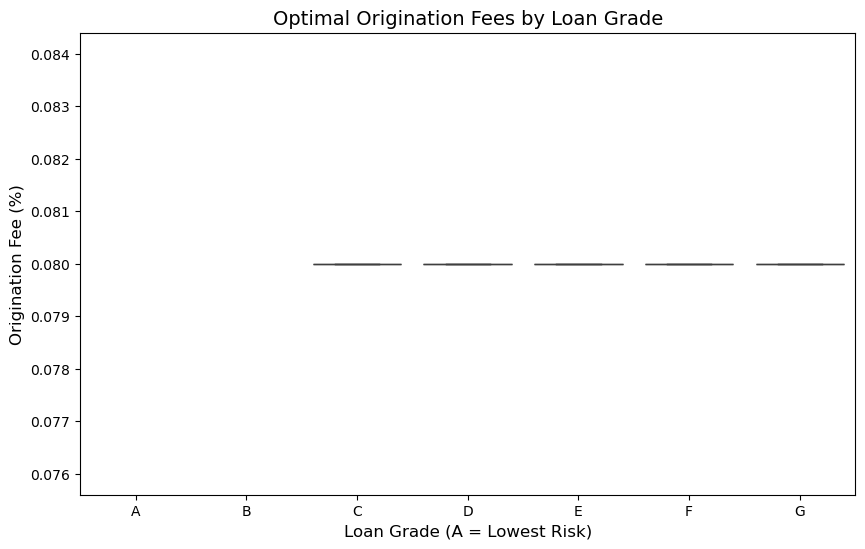

/var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/ipykernel_27888/1777586373.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


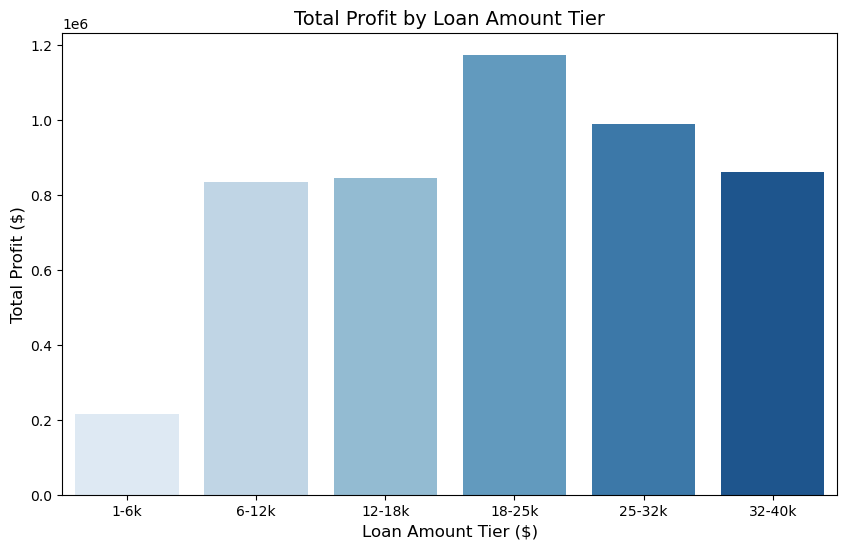

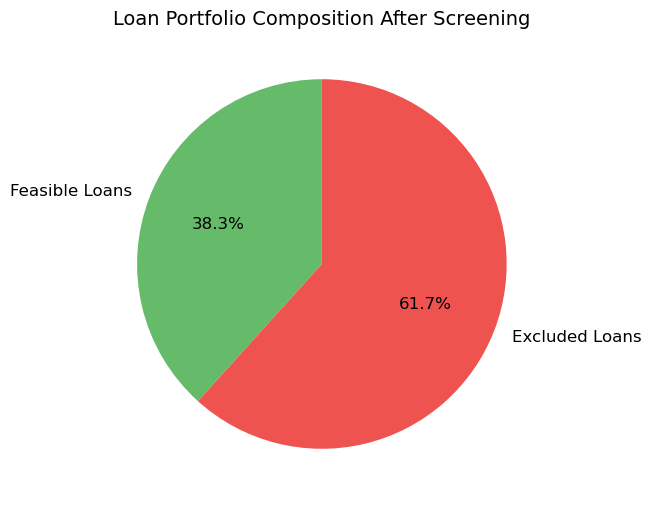

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------
# Prepare visualization data
# --------------------------------------------------

# Extract optimal fees and merge with loan metadata
optimal_fees = [var.varValue for var in fee_vars]  # List of optimal fees from the model
feasible_df['optimal_fee'] = optimal_fees  # Append to feasible loans DataFrame
feasible_df['profit'] = feasible_df['loan_amount'] * feasible_df['optimal_fee']  # Calculate per-loan profit

# --------------------------------------------------
# Figure 1: Optimal Fee Distribution by Loan Grade
# --------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='grade', 
    y='optimal_fee', 
    data=feasible_df,
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G']  # Enforce grade order
)
plt.title("Optimal Origination Fees by Loan Grade", fontsize=14)
plt.xlabel("Loan Grade (A = Lowest Risk)", fontsize=12)
plt.ylabel("Origination Fee (%)", fontsize=12)
plt.savefig('fee_bygrade.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# Figure 2: Profit Contribution by Loan Amount Tier
# --------------------------------------------------
# Bin loans using Lending Club's origination fee tiers
feasible_df['amount_tier'] = pd.cut(
    feasible_df['loan_amount'],
    bins=[0, 6000, 12000, 18000, 25000, 32000, 40000],
    labels=['1-6k', '6-12k', '12-18k', '18-25k', '25-32k', '32-40k']
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='amount_tier',
    y='profit',
    data=feasible_df,
    estimator=sum,
    errorbar=None,
    palette='Blues'
)
plt.title("Total Profit by Loan Amount Tier", fontsize=14)
plt.xlabel("Loan Amount Tier ($)", fontsize=12)
plt.ylabel("Total Profit ($)", fontsize=12)
plt.savefig('profit_bytier.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# Figure 3: Feasible vs Excluded Loans
# --------------------------------------------------
plt.figure(figsize=(8, 6))
plt.pie(
    [len(feasible_df), len(df) - len(feasible_df)],
    labels=['Feasible Loans', 'Excluded Loans'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66BB6A', '#EF5350'],
    textprops={'fontsize': 12}
)
plt.title("Loan Portfolio Composition After Screening", fontsize=14)
plt.savefig('loancomposition.png', dpi=300, bbox_inches='tight')
plt.show()